In [1]:
import os, gc, torch, PIL, pickle

import pandas as pd
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from utils.plot import plot_losses, plot_train_val_evaluators
from PIL import Image
from models.load import get_model_label, get_model_name, get_current_epoch, get_dataset_label, get_trained_model

from data.paths import MIMIC_EYE_PATH

import utils.print as print_f
from utils.init import reproducibility, clean_memory_get_device

# from models.load import TrainedModels
## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
from enum import Enum

class TrainedModels(Enum):
    object_detection_and_heatmap_generation = "val_ar_0_5102_ap_0_1966_test_ar_0_5504_ap_0_2362_epoch18_02-14-2023 07-03-16_basline_test"
    object_detection_alone = "val_ar_0_5550_ap_0_1937_test_ar_0_5481_ap_0_1928_epoch19_02-14-2023 16-45-12_basline_test"


In [4]:
naming_map = {
    TrainedModels.object_detection_and_heatmap_generation: "with fixations",
    TrainedModels.object_detection_alone: "without_fixations",
}


In [5]:
def get_thrs_evaluation_df(
    models: List[TrainedModels], dataset, disease="all", iobb_thrs=0.5, score_thrs=0.05
):
    all_models_eval_data = {}
    for select_model in models:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[select_model.value] = eval_data

    return pd.DataFrame(
        [
            {
                "model": str(select_model).split(".")[-1],
                **all_models_eval_data[select_model.value][iobb_thrs][0],
            }
            for select_model in models
        ]
    )[["model", "ap", "ar"]]



In [6]:
def plot_iou_result(
    models: List[TrainedModels],
    datasets,
    disease="all",
    figsize=(10, 10),
    include_recall=False,
    score_thrs=0.05,
):

    cm = plt.get_cmap("rainbow")
    NUM_COLORS = len(models)

    all_models_eval_data = {dataset: {} for dataset in datasets}

    for select_model in models:
        for dataset in datasets:
            with open(
                os.path.join(
                    "eval_results",
                    f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
                ),
                "rb",
            ) as f:
                eval_data = pickle.load(f)
                all_models_eval_data[dataset][select_model.value] = eval_data

    fig, axes = plt.subplots(
        len(datasets),
        2 if include_recall else 1,
        figsize=figsize,
        dpi=120,
        sharex=True,
        squeeze=False,
    )

    for i, dataset in enumerate(datasets):
        axes[i, 0].set_title(f"[{dataset}] - Average Precision")
        axes[i, 0].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for select_model in models:
            axes[i, 0].plot(
                all_models_eval_data[dataset][select_model.value].keys(),
                [
                    v[0]["ap"]
                    for v in all_models_eval_data[dataset][select_model.value].values()
                ],
                marker="o",
                label=get_model_name(select_model, naming_map=naming_map),
                # color="darkorange",
            )
        axes[i, 0].legend(loc="lower left")
        axes[i, 0].set_xlabel("IoBB threshold")

        if include_recall:

            axes[i, 1].set_title(f"[{dataset}] - Average Recall")
            axes[i, 1].set_prop_cycle(
                "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
            )

            for select_model in models:
                axes[i, 1].plot(
                    all_models_eval_data[dataset][select_model.value].keys(),
                    [
                        v[0]["ar"]
                        for v in all_models_eval_data[dataset][
                            select_model.value
                        ].values()
                    ],
                    marker="o",
                    label=get_model_name(select_model, naming_map=naming_map),
                    # color="darkorange",
                )

            axes[i, 1].legend(loc="lower left")
            axes[i, 1].set_xlabel("IoBB threshold")

    plt.tight_layout()
    plt.plot()
    plt.pause(0.01)

    return fig

In [7]:
def showModelOnDatasets(
    select_model, datasets, disease="all", figsize=(10, 10), include_recall=False,
    score_thrs=0.05,
):
    """
    This function used for detecting the overfitting dataset.    
    """
    cm = plt.get_cmap("gist_rainbow")
    NUM_COLORS = len(datasets)

    all_models_eval_data = {}
    for dataset in datasets:
        with open(
            os.path.join(
                "eval_results", f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[dataset] = eval_data

    fig, axes = plt.subplots(
        2 if include_recall else 1, figsize=figsize, dpi=120, sharex=True, squeeze=False,
    )

    axes = axes[0]

    fig.suptitle(get_model_name(select_model, naming_map=naming_map))

    axes[0].set_title("Average Precision")
    axes[0].set_prop_cycle(
        "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
    )

    for dataset in datasets:
        axes[0].plot(
            all_models_eval_data[dataset].keys(),
            [v[0]["ap"] for v in all_models_eval_data[dataset].values()],
            marker="o",
            label=dataset,
            # color="darkorange",
        )
    axes[0].legend(loc="lower left")

    if include_recall:
        axes[1].set_title("Average Recall")
        axes[1].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for dataset in datasets:
            axes[1].plot(
                all_models_eval_data[dataset].keys(),
                [v[0]["ar"] for v in all_models_eval_data[dataset].values()],
                marker="o",
                label=dataset,
                # color="darkorange",
            )

        axes[1].legend(loc="lower left")
        axes[1].set_xlabel("IoBB")
        
    plt.tight_layout()
    plt.plot()
    plt.pause(0.01)

    return fig


In [8]:
def showModelOnScoreThrs(
    select_model: TrainedModels, dataset: str, disease="all", figsize=(10, 10), include_recall=False,
    score_thresholds=[0.5, 0.3, 0.2, 0.1, 0.05],
):
    """
    This function used for detecting the overfitting dataset.    
    """
    cm = plt.get_cmap("gist_rainbow")
    NUM_COLORS = len(score_thresholds)

    all_models_eval_data = {}
    for score_thrs in score_thresholds:
        with open(
            os.path.join(
                "eval_results", f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[score_thrs] = eval_data

    fig, axes = plt.subplots(
        2 if include_recall else 1, figsize=figsize, dpi=80, sharex=True, squeeze=False,
    )

    axes = axes[0]

    fig.suptitle(get_model_name(select_model, naming_map=naming_map))

    axes[0].set_title("Average Precision")
    axes[0].set_prop_cycle(
        "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
    )

    for score_thrs in score_thresholds:
        axes[0].plot(
            all_models_eval_data[score_thrs].keys(),
            [v[0]["ap"] for v in all_models_eval_data[score_thrs].values()],
            marker="o",
            label=f"score_thrs={str(score_thrs)}",
            # color="darkorange",
        )
    axes[0].legend(loc="lower left")

    if include_recall:
        axes[1].set_title("Average Recall")
        axes[1].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for score_thrs in score_thresholds:
            axes[1].plot(
                all_models_eval_data[score_thrs].keys(),
                [v[0]["ar"] for v in all_models_eval_data[score_thrs].values()],
                marker="o",
                label=f"score_thrs={str(score_thrs)}",
                # color="darkorange",
            )

        axes[1].legend(loc="lower left")
        axes[1].set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig


In [9]:
def plot_training_progress(trained_models):
    for trained_model in trained_models:
        _, train_info, _ = get_trained_model(
            trained_model,
            device,
        )

        print_f.print_title("Training Info")
        print(train_info)

        plot_train_val_evaluators(
            train_ap_ars=train_info.train_ap_ars, val_ap_ars=train_info.val_ap_ars,
        )

        plot_losses(train_info.train_data, train_info.val_data)


In [10]:
def showModelsOnDatasets(
    select_models, datasets, disease="all", figsize=(10, 10),
    score_thrs=0.05,
):
    """
    This function used for detecting the overfitting dataset.    
    """
    cm = plt.get_cmap("gist_rainbow")
    NUM_COLORS = len(datasets)

    fig, axes = plt.subplots(
        1 , len(select_models) , figsize=figsize, dpi=120, sharex=True, sharey=True ,squeeze=False,
    )

    fig.suptitle("Average Precision")

    for c_i , select_model,in enumerate(select_models):
        all_models_eval_data = {}
        for dataset in datasets:
            with open(
                os.path.join(
                    "eval_results", f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
                ),
                "rb",
            ) as f:
                eval_data = pickle.load(f)
                all_models_eval_data[dataset] = eval_data


        ax = axes[0][c_i]

        ax.set_title(f"{get_model_name(select_model, naming_map=naming_map)}")
        ax.set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for dataset in datasets:
            ax.plot(
                all_models_eval_data[dataset].keys(),
                [v[0]["ap"] for v in all_models_eval_data[dataset].values()],
                marker="o",
                label=dataset,
                # color="darkorange",
            )
        ax.legend(loc="lower left")
        ax.set_xlabel("IoBB threshold")
    plt.tight_layout()
    plt.plot()
    plt.pause(0.01)

    return fig


In [11]:
from models.utils import get_model_size_in_MB

def print_num_params(trained_models, naming_map):
    for trained_model in trained_models:
        model,_, _,_ = get_trained_model(
            trained_model,
            device,
        )

        print(f"| Model: [{naming_map[trained_model]}] | Size: [{get_model_size_in_MB(model):.2f} MB] |")

In [15]:
from data.constants import DEFAULT_REFLACX_LABEL_COLS

In [16]:
from collections import OrderedDict

def get_mAP_mAR(
    models: List[TrainedModels],
    datasets: List[str],
    naming_map,
    score_thrs: float = 0.05,
):
    # fix this 
    labels_cols = DEFAULT_REFLACX_LABEL_COLS + ["all"]
    # score_thrs = 0.05

    all_df = {d: {} for d in labels_cols}

    for disease_str in labels_cols:
        for select_model in models:
            model_path = select_model.value
            eval_df = pd.read_csv(
                os.path.join(
                    "eval_results",
                    f"{model_path}_{disease_str}_score_thrs{score_thrs}.csv",
                ),
                index_col=0,
            )
            all_df[disease_str][model_path] = eval_df

    # eval_dataset = 'val' # ['test', 'val', 'our']

    for eval_dataset in datasets:
        model_dfs = OrderedDict({})

        for select_model in models:
            model_path = select_model.value
            model_name = get_model_name(
                select_model, naming_map=naming_map
            )  # str(select_model).split(".")[-1]
            # Pick dataset

            model_eval = []
            for disease_str in labels_cols:
                model_eval.append(
                    {
                        **dict(
                            all_df[disease_str][model_path][
                                all_df[disease_str][model_path]["dataset"]
                                == eval_dataset
                            ].iloc[0]
                        ),
                        "disease": disease_str,
                    }
                )

            # model_dfs[model_name] = pd.DataFrame(model_eval)[
            #     ["disease", f"AP@[IoBB = 0.50:0.95]", f"AR@[IoBB = 0.50:0.95]"]
            # ]

            model_dfs[model_name] = pd.DataFrame(model_eval)[
                ["disease", f"AP@[IoBB = 0.50]", f"AR@[IoBB = 0.50]"]
            ]

        for idx, k in enumerate(model_dfs.keys()):
            if idx == 0:
                # create the merged df
                merged_df = model_dfs[k].copy()
                merged_df.columns = [
                    "disease" if c == "disease" else f"{c}_{k}"
                    for c in merged_df.columns
                ]
            else:
                df = model_dfs[k].copy()
                df.columns = [
                    "disease" if c == "disease" else f"{c}_{k}" for c in df.columns
                ]
                merged_df = merged_df.merge(df, "left", on="disease",)

        print_f.print_title(f"Dataset [{eval_dataset}]")
        display(merged_df)

        merged_df.to_csv(
            os.path.join(f"{eval_dataset}_dataset_class_ap_score_thrs_{score_thrs}.csv")
        )

        return merged_df

In [17]:
print_num_params([TrainedModels.object_detection_alone, TrainedModels.object_detection_and_heatmap_generation], naming_map)

Using pretrained backbone. mobilenet_v3
Using SGD as optimizer with lr=0.01
| Model: [without_fixations] | Size: [21.38 MB] |
Using pretrained backbone. mobilenet_v3
Using SGD as optimizer with lr=0.01
| Model: [with fixations] | Size: [22.79 MB] |


In [18]:
merged_df = get_mAP_mAR(
    models= [
        TrainedModels.object_detection_alone,
        TrainedModels.object_detection_and_heatmap_generation,
    ],
    datasets= ["test"],#["train", "val", "test", "our"],
    score_thrs= 0.05,
    naming_map=naming_map
)

====================Dataset [test]====================


,disease,AP@[IoBB = 0.50]_without_fixations,AR@[IoBB = 0.50]_without_fixations,AP@[IoBB = 0.50]_with fixations,AR@[IoBB = 0.50]_with fixations
0,Pulmonary edema,0.197217,0.663317,0.188293,0.517588
1,Enlarged cardiac silhouette,0.293517,0.696751,0.341587,0.631769
2,Consolidation,0.213922,0.646884,0.227946,0.587537
3,Atelectasis,0.132559,0.451104,0.224089,0.611987
4,Pleural abnormality,0.125009,0.279703,0.184145,0.386139
5,all,0.193601,0.548636,0.233016,0.550649


In [19]:
for col in merged_df.columns[1:]:
    merged_df[col] = merged_df[col].apply(lambda x: f"{x*100:.4f}")

In [20]:
merged_df

,disease,AP@[IoBB = 0.50]_without_fixations,AR@[IoBB = 0.50]_without_fixations,AP@[IoBB = 0.50]_with fixations,AR@[IoBB = 0.50]_with fixations
0,Pulmonary edema,19.7217,66.3317,18.8293,51.7588
1,Enlarged cardiac silhouette,29.3517,69.6751,34.1587,63.1769
2,Consolidation,21.3922,64.6884,22.7946,58.7537
3,Atelectasis,13.2559,45.1104,22.4089,61.1987
4,Pleural abnormality,12.5009,27.9703,18.4145,38.6139
5,all,19.3601,54.8636,23.3016,55.0649


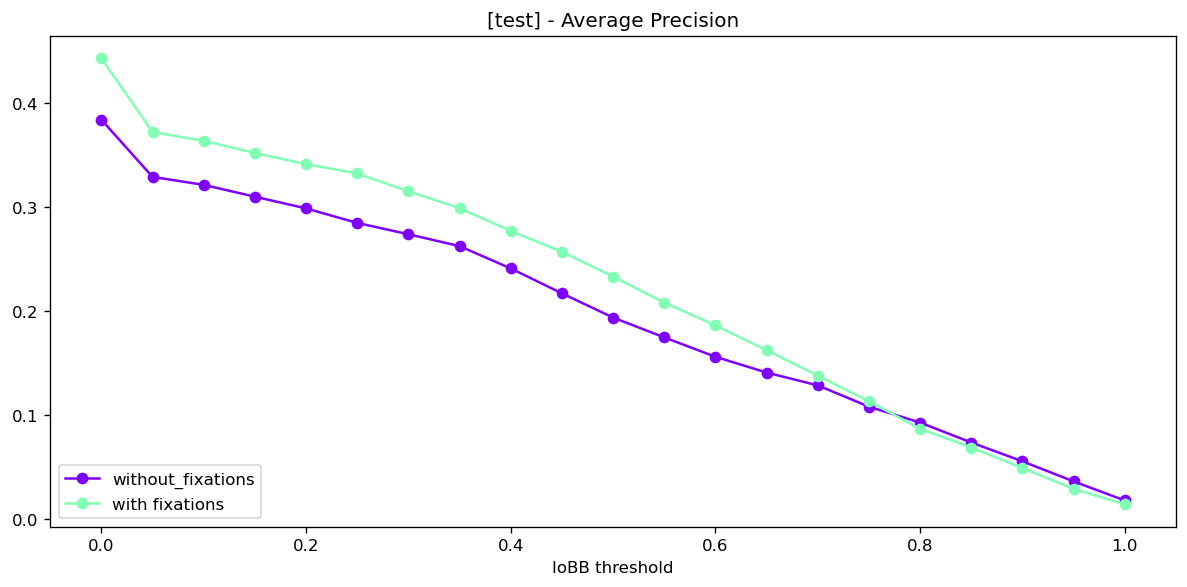

In [21]:
_ = plot_iou_result(
    [
        TrainedModels.object_detection_alone,
        TrainedModels.object_detection_and_heatmap_generation,
    ],
    ["test"], #["train", "val", "test"],
    figsize=(10, 5),
    include_recall=False,
    score_thrs=0.05,
)

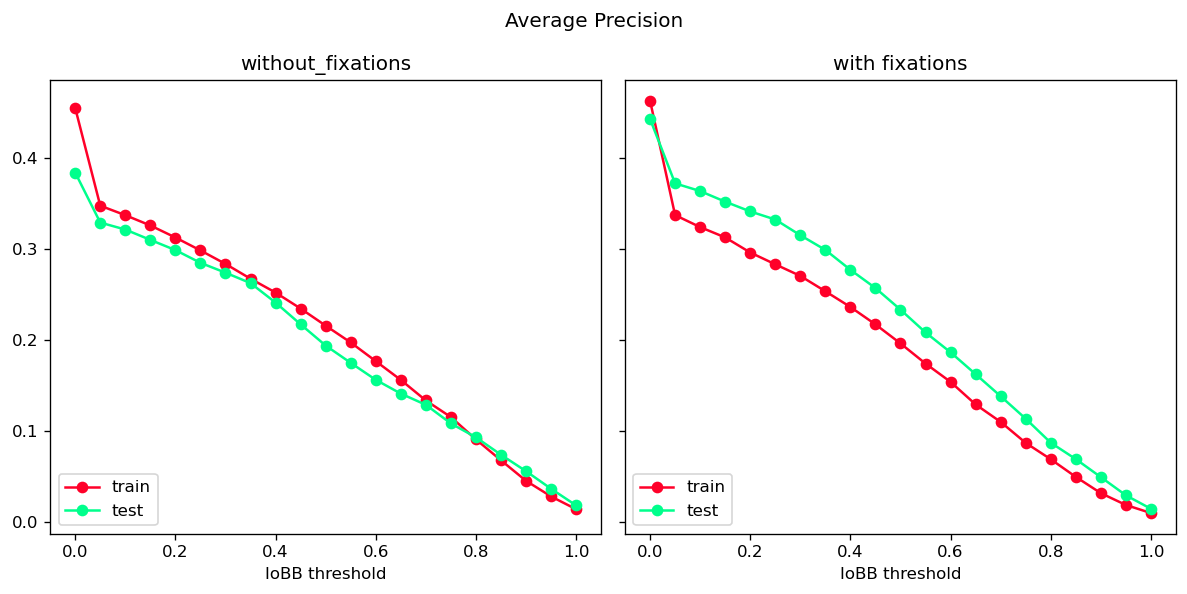

In [22]:
axes = showModelsOnDatasets(
    [
        TrainedModels.object_detection_alone,
        TrainedModels.object_detection_and_heatmap_generation,
        # TrainedModels.CXR_Clinical_fusion1,
        # TrainedModels.CXR_Clinical_fusion2,
    ],
    ["train", "test"],  # ["train", "val", "test"]
    figsize=(10, 5),
    score_thrs=0.05,
)

